## DBSACAN: Student Assessment Outlier Detection

### Dataset Description: Student Assessment Questionnaires and Quiz Scores

The dataset `assessment_quiz_generated.csv` contains information derived from student assessment questionnaires and their corresponding quiz scores.

The dataset comprises the following attributes:

- **`timestamp`**  
  The date and time when the assessment was submitted, formatted as `yyyy-mm-dd hh:mm:ss timezone`.

- **`netid`**  
  The encoded NetID of the student. Valid NetIDs must have a string length between 8 and 14 characters (inclusive). Entries falling outside this range are considered invalid.

- **`ruid`**  
  The encoded RUID of the student. A valid RUID is expected to contain exactly 18 characters. Any deviation from this length is considered invalid.

- **Skill Proficiency Columns**  
  The following columns record students’ self-assessed proficiency levels in specific skills, rated on scales ranging from 0 up to a multiple of 5 (depending on the number of questions per topic).

  - 0: `data_structures`  
  - 1: `calculus_and_linear_algebra`  
  - 2: `probability_and_statistics`  
  - 3: `data_visualization`  
  - 4: `python_libraries`  
  - 5: `shell_scripting`  
  - 6: `sql`  
  - 7: `python_scripting`  
  - 8: `jupyter_notebook`  
  - 9: `regression`  
  - 10: `programming_languages`  
  - 11: `algorithms`  
  - 12: `complexity_measures`  
  - 13: `visualization_tools`  
  - 14: `massive_data_processing`

- **`quiz_score` (New Added column to the previous dataset)**
  The score obtained by the student in the quiz, represented as a floating-point number between 0 and 100 (inclusive).

```mermaid
flowchart TD
    A([Start]) --> B[Load Dataset]
    B --> C[Data Preprocessing]
    C --> D[KNN Distance Calculation]
    D --> E[Elbow Method for Epsilon Selection]
    E --> F[DBSCAN Clustering]
    F --> G[Outlier Detection]
    G --> H[Visualization]
    H --> I([End])
```

### Tasks

In this assignment, we will utilize the DBSCAN algorithm to identify outliers in the dataset based on students' self-assessed skill proficiency and their quiz scores. 

1. **Data Preprocessing**: Load the dataset and preprocess it by normalizing the skill proficiency scores and quiz scores.
2. **KNN Distance Calculation**: Compute the k-nearest neighbor distances to help determine an appropriate epsilon value for DBSCAN.
3. **Elbow Method for Epsilon Selection**: Plot the k-distance graph and use the elbow method to select a suitable epsilon value.
4. **DBSCAN Clustering**: Apply the DBSCAN algorithm using the selected epsilon and a suitable minimum samples value to cluster the data.
5. **Outlier Detection**: Identify outliers based on the clustering results from DBSCAN.
6. **Visualization**: Visualize the clustering results and highlight the detected outliers.

### Setup Code

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if __name__ == "__main__":
    skill_columns = [
        'data_structures',
        'calculus_and_linear_algebra',
        'probability_and_statistics',
        'data_visualization',
        'python_libraries',
        'shell_scripting',
        'sql',
        'python_scripting',
        'jupyter_notebook',
        'regression',
        'programming_languages',
        'algorithms',
        'complexity_measures',
        'visualization_tools',
        'massive_data_processing'
    ]

### Task 1: Data Preprocessing

#### Subtask 1.1: Load Data

In [3]:
def load_data(file_path):
    """
    Load the dataset from a CSV file.
    IN: file_path, str, path to the CSV file
    OUT: df, pd.DataFrame, loaded data
    """
    # Your code here
    df = pd.read_csv(file_path)
    return df

In [4]:
if __name__ == "__main__":
    FILE_PATH = 'assessment_quiz_generated.csv'
    df = load_data(FILE_PATH)
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   timestamp                    105 non-null    object 
 1   netid                        105 non-null    object 
 2   ruid                         105 non-null    object 
 3   data_structures              105 non-null    int64  
 4   calculus_and_linear_algebra  105 non-null    int64  
 5   probability_and_statistics   105 non-null    int64  
 6   data_visualization           105 non-null    int64  
 7   python_libraries             105 non-null    int64  
 8   shell_scripting              105 non-null    int64  
 9   sql                          105 non-null    int64  
 10  python_scripting             105 non-null    int64  
 11  jupyter_notebook             105 non-null    int64  
 12  regression                   105 non-null    int64  
 13  programming_language

#### Subtask 1.2: Scale Data

In [12]:
def scale_data(df, columns):
    """
    Scale the numerical features with z-Score normalization.
    IN: df, pd.DataFrame, data with numerical features
        columns, list of str, columns to be scaled
    OUT: df_scaled, pd.DataFrame, dataframe with specified columns scaled
    """
    df_scaled = df.copy()

    # Your code here
    for col in columns:
        mean = df_scaled[col].mean()
        std = df_scaled[col].std()
        df_scaled[col] = (df_scaled[col] - mean) / std

    

    return df_scaled

In [13]:
if __name__ == "__main__":
    df_scaled = scale_data(df, columns=[*skill_columns, 'quiz_score'])
    print("Data scaled successfully.")
    print("Scaled data shape:", df_scaled.shape)

Data scaled successfully.
Scaled data shape: (105, 19)


### Task 2: Determine Epsilon for DBSCAN

#### Subtask 2.1: Calculate K-Nearest Neighbors Distances

In [14]:
def calculate_knn_distances(data, n_neighbors):
    """
    Calculate the distance to the k-th nearest neighbor for each point.
    IN: data, np.ndarray of shape (n_samples, n_features), scaled data
        n_neighbors, int, the 'k' in k-NN
    OUT: distances, np.ndarray of shape (n_samples,), sorted distances to the k-th nearest neighbor
    """
    # Your code here
    knnClassifier = NearestNeighbors(n_neighbors=n_neighbors).fit(data)

    distances, indices = knnClassifier.kneighbors(data)

    kth_distances = distances[:, -1]

    kth_distances = np.sort(kth_distances)
    

    return kth_distances

In [15]:
if __name__ == "__main__":
    data_for_clustering = df_scaled[[*skill_columns, 'quiz_score']].values
    # MinPts is often set to 2 * dimensions
    MIN_PTS = 2 * data_for_clustering.shape[1]
    distances = calculate_knn_distances(data_for_clustering, MIN_PTS)
    print(f"Calculated k-NN distances for k={MIN_PTS}.")

Calculated k-NN distances for k=32.


#### Subtask 2.2: Plot K-Distance Graph (Elbow Method)

In [16]:
def plot_k_distance_graph(distances):
    """
    Plot the k-distance graph to find the optimal epsilon.
    IN: distances, np.ndarray, sorted distances to the k-th nearest neighbor
    OUT: None
    """
    plt.figure(figsize=(10, 5))
    # Your code here
    plt.plot(distances)
    
    plt.title('K-Distance Graph')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel(f'{MIN_PTS}-th Nearest Neighbor Distance')
    plt.grid(True)
    plt.show()

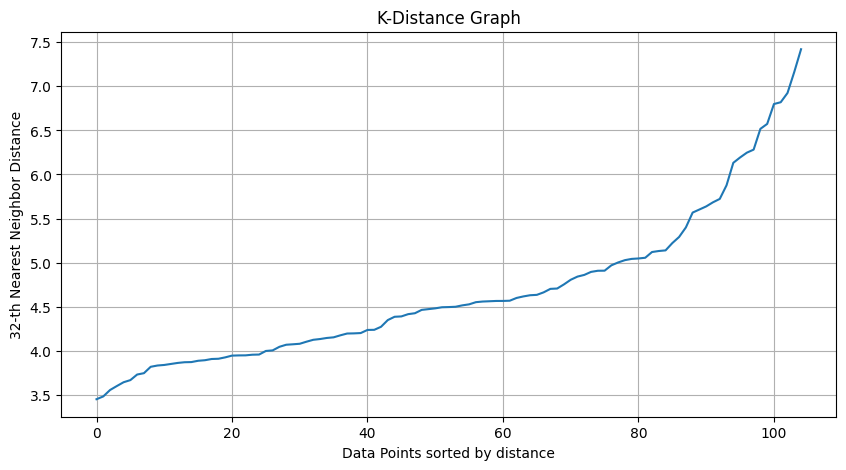

In [17]:
if __name__ == "__main__":
    plot_k_distance_graph(distances)
    # From the plot, let's estimate epsilon
    EPSILON = 5.1 # This value is an estimate from the elbow point of the plot

### Task 3: DBSCAN Clustering and Outlier Detection

#### Subtask 3.1: Perform DBSCAN Clustering

In [ ]:
def perform_dbscan(data, eps, min_samples):
    """
    Perform DBSCAN clustering.
    IN: data, np.ndarray of shape (n_samples, n_features), scaled data
        eps, float, The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples, int, The number of samples in a neighborhood for a point to be considered as a core point.
    OUT: labels, np.ndarray of shape (n_samples,), cluster labels for each point. Outliers are labeled -1.
    """
    # Your code here
    

    return labels

In [12]:
if __name__ == "__main__":
    cluster_labels = perform_dbscan(data_for_clustering, EPSILON, MIN_PTS)
    print("DBSCAN clustering performed.")
    print("Cluster labels:", np.unique(cluster_labels))

DBSCAN clustering performed.
Cluster labels: [-1  0]


#### Subtask 3.2: Identify Outliers

In [ ]:
def identify_outliers(df, labels):
    """
    Identify outliers from the DBSCAN results.
    IN: df, pd.DataFrame, original dataframe (or the one used for clustering)
        labels, np.ndarray of shape (n_samples,), cluster labels from DBSCAN
    OUT: outliers_df, pd.DataFrame, dataframe containing only the outliers
    """
    # Your code here
    return outliers_df

In [14]:
if __name__ == "__main__":
    outliers = identify_outliers(df_scaled, cluster_labels)
    print(f"Found {len(outliers)} outliers.")
    print("First 5 outliers:\n", outliers.head())

Found 6 outliers.
First 5 outliers:
                     timestamp         netid                ruid  \
4   2025-09-03 12:39:05 -1000  54490a53500a  fceeaca5a5fbeea3ac   
8   2025-09-03 13:29:53 -0900  f3edfaf9faa5  b8a9e2e1e1baaee7e4   
47  2025-09-03 22:07:40 +0000  dfd49bc1c69b  17054b4e4e140f4b4f   
49  2025-09-03 22:09:39 +0000    6668646765  05175f5c5c03145d5c   
61  2025-09-03 23:31:04 +0100    70686a6263  8191d8d8d88b94ddd1   

    data_structures  calculus_and_linear_algebra  probability_and_statistics  \
4          1.643958                     0.139276                    0.947570   
8          0.399678                     1.169135                    0.874358   
47        -0.052788                    -1.920442                    0.435087   
49         0.739027                     0.551220                    1.679688   
61         0.852143                     0.345248                    0.874358   

    data_visualization  python_libraries  shell_scripting       sql  \
4       

### Task 4: Visualization

#### Subtask 4.1: Reduce Dimensionality using PCA

In [ ]:
def reduce_dimensionality(data, n_components=2):
    """
    Reduce dimensionality of the data using PCA for visualization.
    IN: data, np.ndarray of shape (n_samples, n_features), scaled data
        n_components, int, number of principal components to keep
    OUT: pca_result, np.ndarray of shape (n_samples, n_components), data reduced to n_components dimensions
    """
    # Your code here
    return pca_result

In [16]:
if __name__ == "__main__":
    pca_data = reduce_dimensionality(data_for_clustering, n_components=2)
    print("Dimensionality reduced using PCA.")
    print("PCA data shape:", pca_data.shape)

Dimensionality reduced using PCA.
PCA data shape: (105, 2)


#### Subtask 4.2: Plot Clusters and Outliers

In [ ]:
def plot_clusters(df, data_pca, labels):
    """
    Plot the clusters and outliers in 2D.
    IN: df, pd.DataFrame, original data
        data_pca, np.ndarray, PCA-reduced data
        labels, np.ndarray, cluster labels from DBSCAN
    OUT: None
    """
    plt.figure(figsize=(12, 8))
    # Your code here

    # label outliers with netid
    # Your code here

    plt.title('DBSCAN Clustering Results (PCA-reduced)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

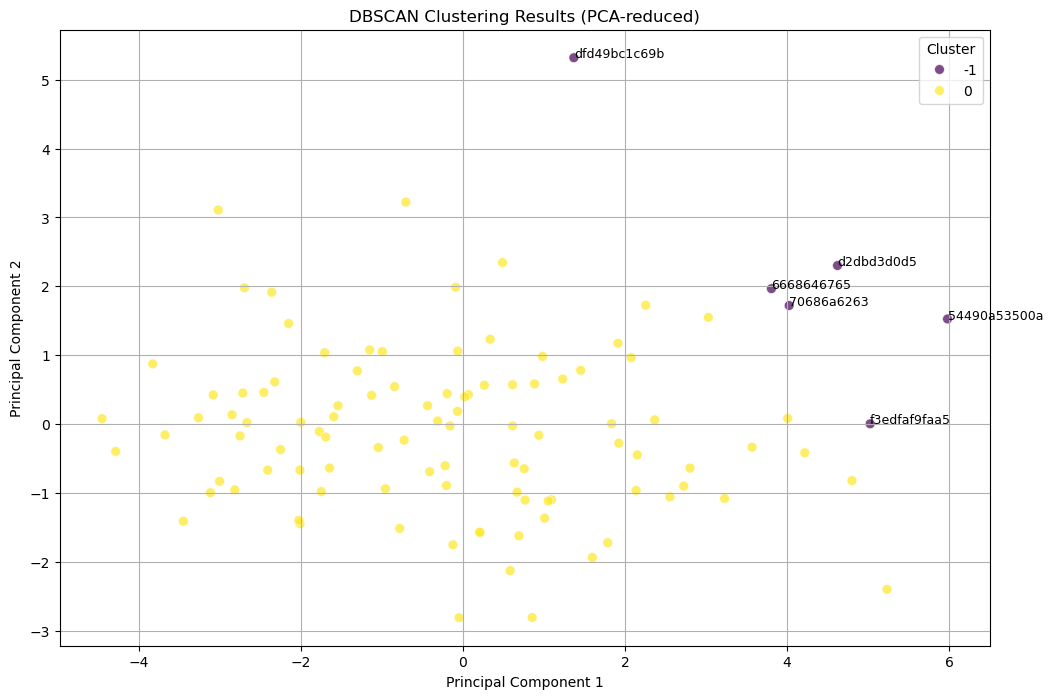

In [18]:
if __name__ == "__main__":
    plot_clusters(df_scaled, pca_data, cluster_labels)